# OpenPoseで体の姿勢を推定してみよう！

OpenPoseとは、コンピュータビジョンの国際学会CVPR2017でカーネギーメロン大学の研究チームが発表した、Deep Learningによる姿勢推定の手法です。   

```"Nose", "Neck", "RShoulder", "RElbow", "RWrist", "LShoulder", "LElbow", "LWrist", "RHip", "RKnee", "RAnkle", "LHip", "LKnee", "LAnkle", "REye", "LEye", "REar", "LEar", "Background"```

の計19個の関節や部位を見つけてくれます。   
従来手法に比べ、左手と右手を区別することができるなど、非常に精度が高いことから、人間行動分析などでも使われています。

- 論文：Zhe Cao, Tomas Simon, Shih-En Wei, Yaser Sheikh, "Realtime Multi-Person 2D Pose Estimation using Part Affinity Fields", CVPR2017. view on https://arxiv.org/abs/1611.08050
- ソースコード：[GitHub](https://github.com/CMU-Perceptual-Computing-Lab/openpose)

**この演習はマシンパワーを必要とするので、低スペックのPCだとフリーズする可能性があります。   
PCのスペックに不安のある方は、基盤センターのPCを利用してください。**

Deep Learningによる画像認識にはいろいろなプラットフォームと実装がありますが、
ここではopencv3.3以上に組み込まれたDeep LearningのライブラリCaffeを使いたいと思います。   
物体検出プログラムを実行するには、学習済みのモデルとプロトテキストが必要です。

- prototxt: ニューラルネットの構造を記述するためのCaffe独自のテキスト形式
- caffeemodel: Caffe形式の学習済みモデル


## 1. モデルのダウンロード

学習済みのモデルをダウンロードします。   

**200MBのファイルです！非常に時間がかかります！従量課金されるネットワーク下では実行しないでください。**

以下を**1回のみ**実行してください。  
ダウンロードされたモデルは、このnotebookが置かれているフォルダ内にある、OpenPoseという名前のフォルダの下に入ります。

In [1]:
# この作業は1回のみで結構です！1回だけ、以下の「'''」を消してから実行してください。

'''
import urllib.request
import os

if not os.path.exists('OpenPose'):
    os.mkdir('OpenPose')

# モデルのダウンロード元
caffemodel_link = 'http://posefs1.perception.cs.cmu.edu/OpenPose/models/pose/coco/pose_iter_440000.caffemodel'
prototxt_link = 'https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/openpose_pose_coco.prototxt'

# モデルのダウンロード先
caffemodel_save = 'OpenPose/pose_iter_440000.caffemodel'
prototxt_save = 'OpenPose/openpose_pose_coco.prototxt'

# ダウンロードの実行
urllib.request.urlretrieve(caffemodel_link, caffemodel_save)
urllib.request.urlretrieve(prototxt_link, prototxt_save)
'''

('OpenPose/openpose_pose_coco.prototxt',
 <http.client.HTTPMessage at 0x10441e358>)

## 2. 実行プログラム

引数として与えられたprototxtとmodelを使い、入力画像imageについて物体検出する関数`OpenPose`を以下のように定義しま
す。   
なお、今回のやり方だと画像中に1名しか映っていない場合しか対応できませんが、OpenPoseの手法としては複数名移っていてもそれぞれ正しく姿勢を推定することが可能です。

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

# 抽出対象の19点
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }
BODY_PARTS_LIST = ["Nose", "Neck", "RShoulder", "RElbow", "RWrist",
               "LShoulder", "LElbow", "LWrist", "RHip", "RKnee",
               "RAnkle", "LHip", "LKnee", "LAnkle", "REye",
               "LEye", "REar", "LEar", "Background"]

# 繋がっている点の組み合わせ
POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

label_colors = np.random.uniform(0, 255, size=(len(BODY_PARTS), 3)) # それぞれの部位に適当な色を割り当てる

def OpenPose(image, prototxt, model, confidence):
    inWidth = 368
    inHeight = 368
    inScaleFactor = 0.003922

    # 画像の読み込み
    image = cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)
    (h, w) = image.shape[:2] # 画像サイズの取得

    # ネットワークの準備
    dnn = cv2.dnn.readNetFromCaffe(prototxt, model)

    # 画像を[inWidth x inHeight]にリサイズし、正規化してblob形式に変換
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (inWidth, inHeight)), 
                                 inScaleFactor, 
                                 (inWidth, inHeight),
                                 (0, 0, 0), 
                                 swapRB=False, 
                                 crop=False)
    dnn.setInput(blob)

    # モデルの適応
    out = dnn.forward()

    points = []
    # 各部位ごとにその座標を特定していく
    for i in range(len(BODY_PARTS)):
        # ヒートマップを求める
        heatMap = out[0, i, :, :]
        
        # 最も確率の高い1点を求める
        _, conf, _, point = cv2.minMaxLoc(heatMap)
        x = (w* point[0]) / out.shape[3]
        y = (h * point[1]) / out.shape[2]
        
        # その部位において、もっとも確率が高かった位置の座標を記録
        points.append((int(x), int(y)) if conf > confidence else None)

    # 連結している部位のペアごとに線を引く
    for pair in POSE_PAIRS:
        # 連結元と連結先の部位の名前を取得
        partFrom = pair[0]
        partTo = pair[1]

        # 連結元と連結先の部位のIDを取得
        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        # 連結元と連結先の両方の点が見つかっていたら、その間に線を引く
        if points[idFrom] and points[idTo]:
            cv2.line(image, points[idFrom], points[idTo], (0, 255, 0), 3)

    # 各部位に対して点と名前を描画
    for i in range(len(BODY_PARTS)):
        cv2.ellipse(image, points[i], (6, 6), 0, 0, 360, label_colors[i], cv2.FILLED)
        cv2.putText(image, BODY_PARTS_LIST[i], points[i], cv2.FONT_HERSHEY_SIMPLEX, 1, label_colors[i], 2)

    # 画像の描画
    plt.figure(figsize=(12, 12))
    plt.imshow(image)
    cv2.imwrite('img/OpenPose.jpg', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

## 3. 画像中に移っている1名の姿勢推定

入力画像をいろいろと変えて結果の変わり方を見てみましょう。   
また、信頼度も変えてみましょう。

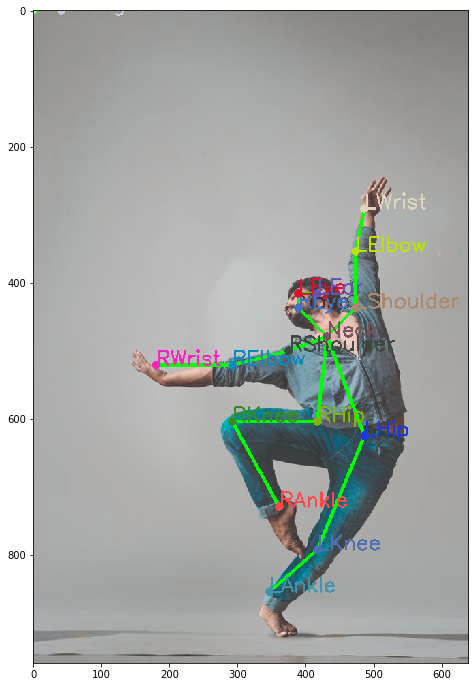

In [3]:
# 検出した領域の信頼度に対する閾値（この値以上の信頼度の領域はOKとする）
confidence = 0.1

#image = 'img/action-active-activity-2091651.jpg' # https://www.pexels.comより取得
#image = 'img/action-energy-active-adult-1921764.jpg' # https://www.pexels.comより取得
#image = 'img/action-adult-athlete-936094.jpg' # https://www.pexels.comより取得
image = 'img/action-adult-balance-1701194.jpg' # https://www.pexels.comより取得

prototxt='OpenPose/openpose_pose_coco.prototxt'
model="OpenPose/pose_iter_440000.caffemodel"

OpenPose(image, prototxt, model, confidence)

なお、OpenPoseは画像中に複数の人が写っている場合も、そのそれぞれの人の姿勢を推定することが可能な手法ですが、それを行うためにはもうひと手間必要になるので、ここでは1名のみが写っていると想定しています。   
このプログラムでは複数名が映っている画像を入力すると、正しく姿勢が推定できません。